In [1]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns
import scipy

In [2]:
sns.set_context("poster", font_scale=1.5)

In [3]:
%matplotlib inline

In [4]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

## Queries
### For base query that generate p_verify_model_master, see comment directly below
* * *

In [ ]:
## for base query, see here: 

In [5]:
engagement_event_query = """

SELECT
	cumulative_cnt_active_activity, 
	cumulative_cnt_engaged_activity,
	cumulative_cnt_video_activity, 
	cumulative_cnt_problem_activity, 
	cumulative_cnt_forum_activity,
	SUM(has_verified) AS cnt_verified,
	COUNT(1) AS cnt_users
FROM 
	ahemphill.p_verify_model_master
WHERE 
	week = 'week_1'
GROUP BY 
	cumulative_cnt_active_activity, 
	cumulative_cnt_engaged_activity,
	cumulative_cnt_video_activity, 
	cumulative_cnt_problem_activity, 
	cumulative_cnt_forum_activity
"""

In [6]:
days_engaged_query = """

SELECT
	cumulative_is_active, 
	cumulative_is_engaged, 
	cumulative_is_engaged_video, 
	cumulative_is_engaged_problem, 
	cumulative_is_engaged_forum,
	SUM(has_verified) AS cnt_verified,
	COUNT(1) AS cnt_users
FROM 
	ahemphill.p_verify_model_master
WHERE 
	week IN ('week_1', 'week_2')
GROUP BY 
	cumulative_is_active, 
	cumulative_is_engaged, 
	cumulative_is_engaged_video, 
	cumulative_is_engaged_problem, 
	cumulative_is_engaged_forum


"""

In [58]:
stacked_query = """

SELECT 
	* 
FROM 
(
	SELECT
		CASE 
			WHEN cumulative_cnt_video_activity = 0 THEN 'no_activity'
			WHEN cumulative_cnt_video_activity between 1 and 5 THEN '1-5'
			WHEN cumulative_cnt_video_activity between 6 and 10 THEN '6-10'
			WHEN cumulative_cnt_video_activity >10  THEN '>10'
		END,
		'video' AS category,
		SUM(has_verified) * 100.0/COUNT(1) AS p_verify,
		COUNT(1) AS cnt_users
	FROM 
		ahemphill.p_verify_model_master
	WHERE 
		week IN ('week_1')
	GROUP BY
		1

	UNION ALL 

	SELECT
		CASE 
			WHEN cumulative_cnt_problem_activity = 0 THEN 'no_activity'
			WHEN cumulative_cnt_problem_activity between 1 and 5 THEN '1-5'
			WHEN cumulative_cnt_problem_activity between 6 and 10 THEN '6-10'
			WHEN cumulative_cnt_problem_activity >10  THEN '>10'
		END,
		'problem' AS category,
		SUM(has_verified) * 100.0/COUNT(1) AS p_verify,
		COUNT(1) AS cnt_users
	FROM 
		ahemphill.p_verify_model_master
	WHERE 
		week IN ('week_1')
    AND
        cumulative_is_engaged > 1
	GROUP BY
		1

	UNION ALL

	SELECT
		CASE 
			WHEN cumulative_cnt_forum_activity = 0 THEN 'no_activity'
			WHEN cumulative_cnt_forum_activity between 1 and 5 THEN '1-5'
			WHEN cumulative_cnt_forum_activity between 6 and 10 THEN '6-10'
			WHEN cumulative_cnt_forum_activity >10  THEN '>10'
		END,
		'forum' AS category,
		SUM(has_verified) * 100.0/COUNT(1) AS p_verify,
		COUNT(1) AS cnt_users
	FROM 
		ahemphill.p_verify_model_master
	WHERE 
		week IN ('week_1')
    AND
        cumulative_is_engaged > 1
	GROUP BY
		1
) a;

"""

In [59]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(engagement_event_query)
extract = cur.fetchall()
events_df = pd.DataFrame(extract)


cur.execute(days_engaged_query)
extract = cur.fetchall()
days_df = pd.DataFrame(extract)

connection.close()

In [10]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(stacked_query)
extract = cur.fetchall()
stacked_df = pd.DataFrame(extract)


connection.close()

In [11]:
stacked_df.head()

,case,category,p_verify,cnt_users
0,>10,video,0.3395838731232737643,8965679
1,6-10,video,0.2016978079216259946,4737285
2,no_activity,video,0.0540431812500484052,91415788
3,1-5,video,0.1305533268541072924,16136701
4,1-5,problem,0.2550621624554027550,6147521


In [12]:
stacked_df['p_verify'] = stacked_df['p_verify'].astype('float64')

In [13]:
## take the smallest p_verify per category, and scale everything else in that category
## according to it

stacked_df['p_verify_scaled'] = stacked_df.merge(
    stacked_df.groupby('category').min().reset_index(), on = 'category', how = 'inner',
         suffixes=('','_min'))['p_verify']/stacked_df.merge(
    stacked_df.groupby('category').min().reset_index(),on = 'category', how = 'inner', suffixes=('','_min'
                                                                                             ))['p_verify_min']

In [14]:
axis_order = ['no_activity', '1-5', '6-10', '>10']

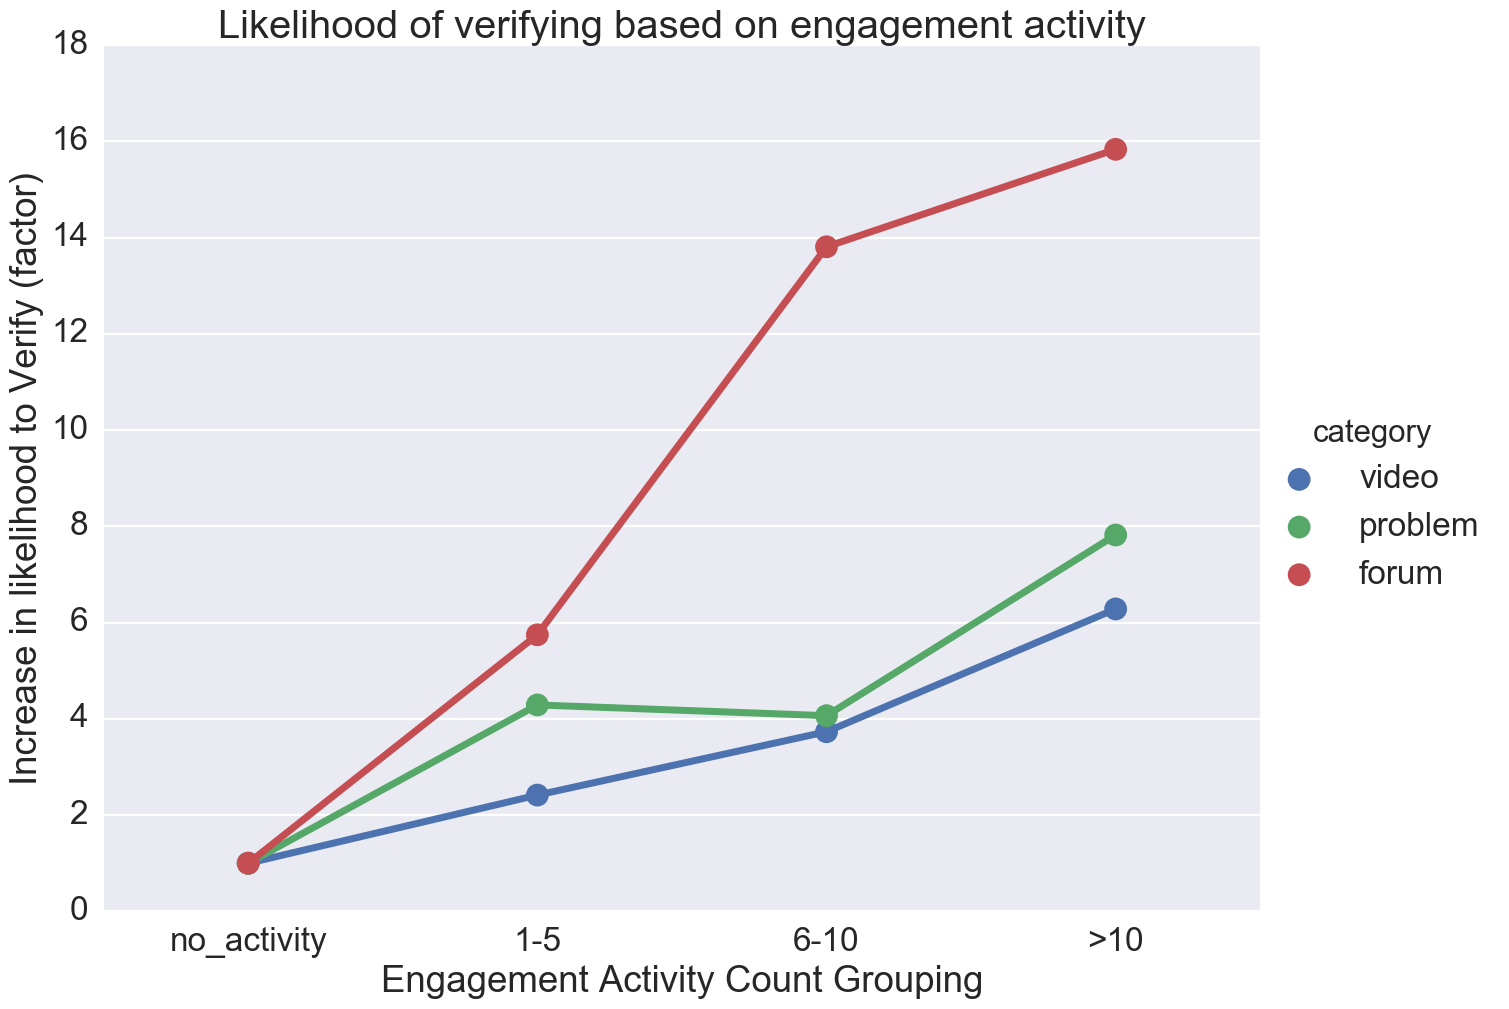

In [15]:
ax = sns.factorplot(

    data = stacked_df,
    x = 'case',
    y = 'p_verify_scaled',
    hue = 'category',
    kind = 'point',
    order = axis_order,
    size = 10,
    aspect = 1.3
)
ax.set(

    title = 'Likelihood of verifying based on engagement activity',
    xlabel = 'Engagement Activity Count Grouping',
    ylabel = 'Increase in likelihood to Verify (factor)'

)

In [54]:
df_agg.head()

,cumulative_cnt_active_activity,cumulative_cnt_engaged_activity,cumulative_cnt_video_activity,cumulative_cnt_problem_activity,cumulative_cnt_forum_activity,cnt_verified,cnt_users
0,1530,85,48,37,0,0,1
1,680,14,1,0,13,0,1
2,536,78,24,54,0,0,1
3,286,37,16,20,1,0,8
4,374,35,12,23,0,0,9


## aggregate, scale, transform

In [60]:
## roll up all users and all verifications

df_agg_engaged_activity = events_df.groupby('cumulative_cnt_engaged_activity').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()
df_agg_video_activity = events_df.groupby('cumulative_cnt_video_activity').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()
df_agg_problem_activity = events_df.groupby('cumulative_cnt_problem_activity').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()
df_agg_forum_activity = events_df.groupby('cumulative_cnt_forum_activity').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()

In [61]:
## dealing with skewed distributions. find the most appropriate transformation based on box-cox

def prep_df(df, metric):

    df['p_verify'] = df['cnt_verified'] * 100.0/df['cnt_users']
    
    df = df[(df[metric] > 0) & (df['p_verify'] > 0)]
        
    df['p_verify_transform'] = scipy.stats.boxcox(df['p_verify'])[0]
    
    col_name = metric + '_transform'
    
    df[col_name] = scipy.stats.boxcox(df[metric])[0]
    
    print ('For %s \n ************* ' % metric)
    print ('P(Verify) Transform lambda is: %f' % scipy.stats.boxcox(df['p_verify'])[1])
    print ('%s Transform lambda is: %f\n' % (metric, scipy.stats.boxcox(df[metric])[1]))

    return df

In [62]:
## generate new df for each metric with the transformed p(verify) and transformed metric

df_agg_engaged_activity = prep_df(df_agg_engaged_activity, 'cumulative_cnt_engaged_activity')
df_agg_video_activity = prep_df(df_agg_video_activity, 'cumulative_cnt_video_activity')
df_agg_problem_activity = prep_df(df_agg_problem_activity, 'cumulative_cnt_problem_activity')
df_agg_forum_activity = prep_df(df_agg_forum_activity, 'cumulative_cnt_forum_activity')

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


For cumulative_cnt_engaged_activity 
 ************* 
P(Verify) Transform lambda is: -0.313712
cumulative_cnt_engaged_activity Transform lambda is: 0.386882

For cumulative_cnt_video_activity 
 ************* 
P(Verify) Transform lambda is: -0.427662
cumulative_cnt_video_activity Transform lambda is: 0.333991

For cumulative_cnt_problem_activity 
 ************* 
P(Verify) Transform lambda is: -0.285505
cumulative_cnt_problem_activity Transform lambda is: 0.437675

For cumulative_cnt_forum_activity 
 ************* 
P(Verify) Transform lambda is: -0.379036
cumulative_cnt_forum_activity Transform lambda is: 0.246225



## sanity checking the transform
* * *

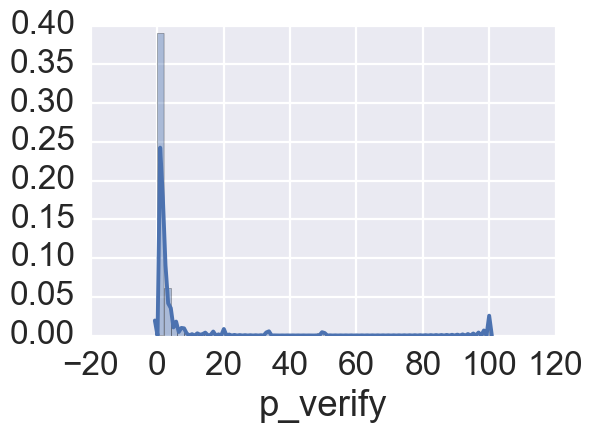

In [63]:
## pre transform

sns.distplot(df_agg_engaged_activity.p_verify)

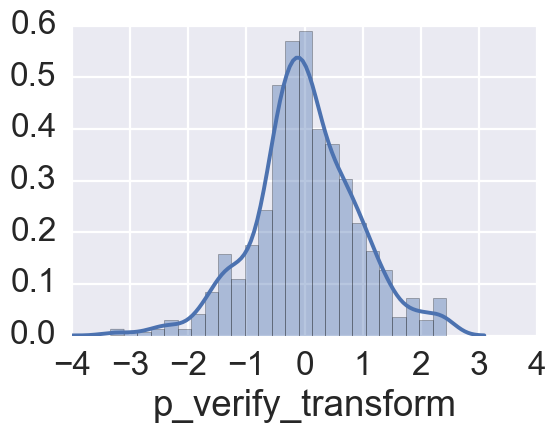

In [64]:
## post transform

sns.distplot(df_agg_engaged_activity.p_verify_transform)

## plot stuff
* * *

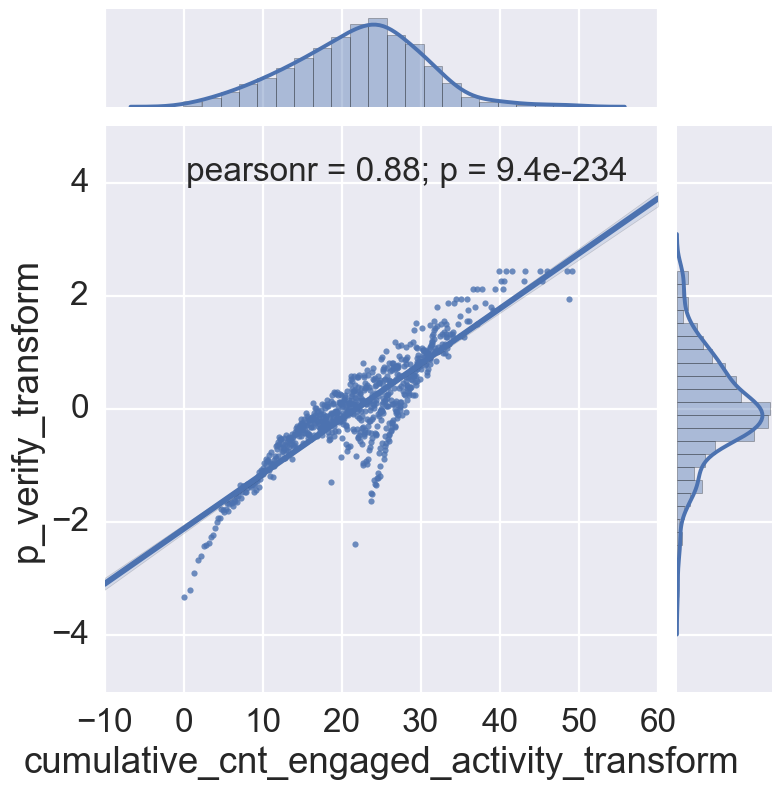

In [65]:
sns.jointplot(
    data = df_agg_engaged_activity,
    x = 'cumulative_cnt_engaged_activity_transform',
    y = 'p_verify_transform',
    size = 8,
    kind = 'reg'

)

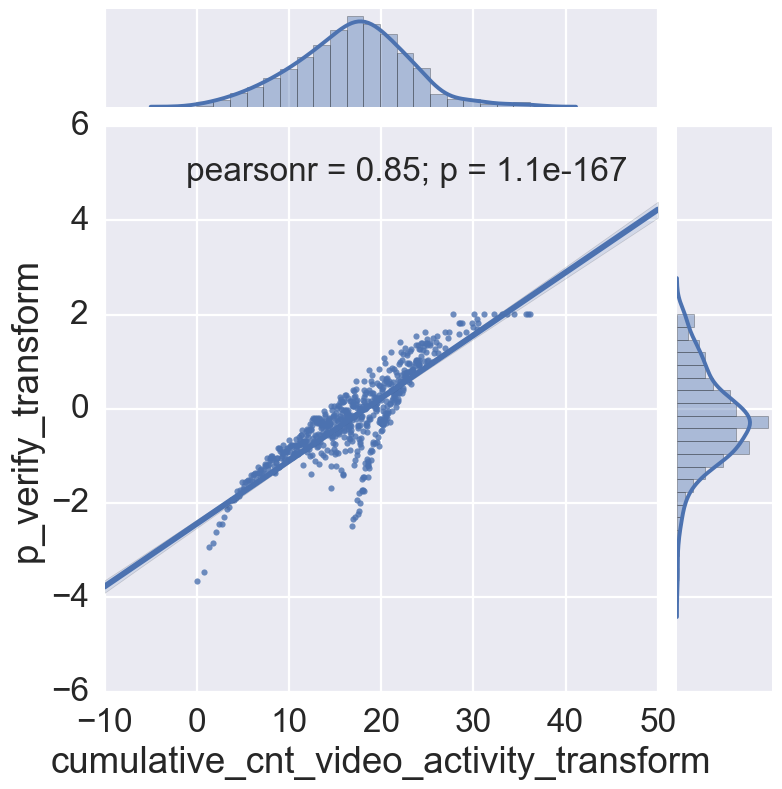

In [66]:
sns.jointplot(
    data = df_agg_video_activity,
    x = 'cumulative_cnt_video_activity_transform',
    y = 'p_verify_transform',
    size = 8,
    kind = 'reg'

)

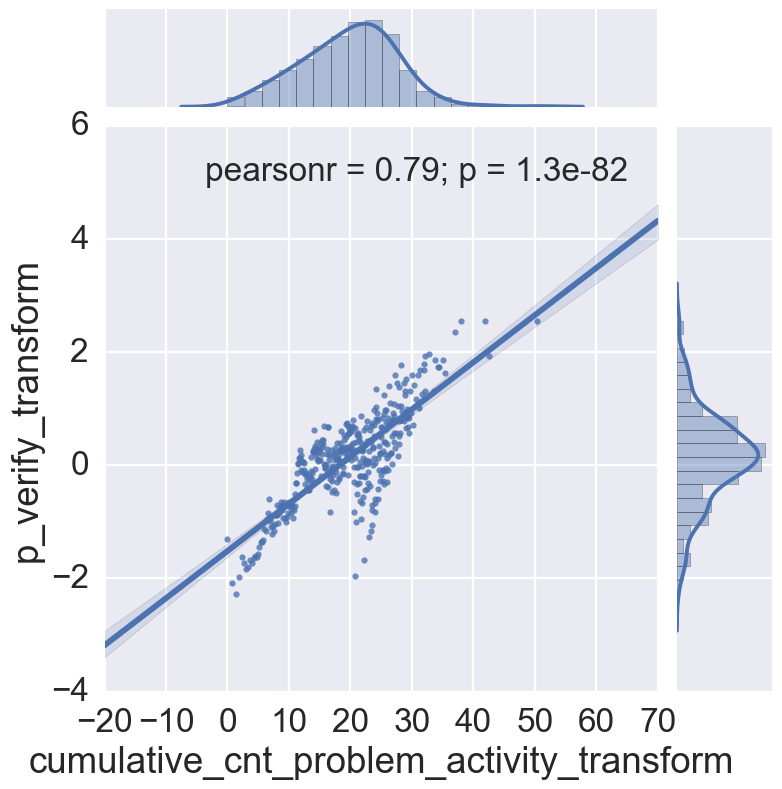

In [67]:
sns.jointplot(
    data = df_agg_problem_activity,
    x = 'cumulative_cnt_problem_activity_transform',
    y = 'p_verify_transform',
    size = 8,
    kind = 'reg'

)

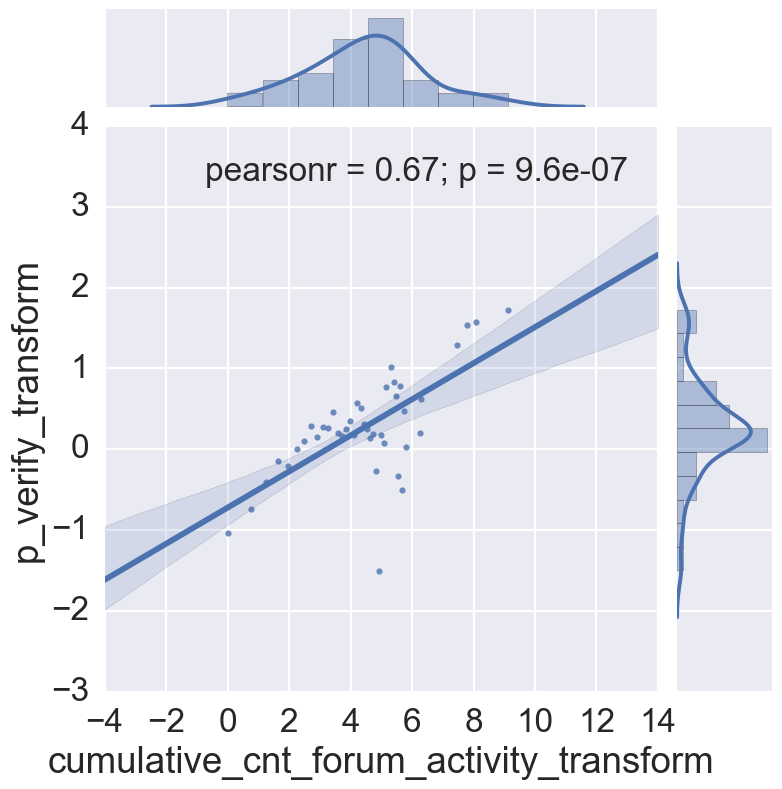

In [68]:
sns.jointplot(
    data = df_agg_forum_activity,
    x = 'cumulative_cnt_forum_activity_transform',
    y = 'p_verify_transform',
    size = 8,
    kind = 'reg'

)

# By days instead of activity count
* * *

In [69]:
df_agg_days.columns

NameError: name 'df_agg_days' is not defined

In [ ]:
df_agg_days_engaged_activity = df_agg_days.groupby('cumulative_is_engaged').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()
df_agg_days_video_activity = df_agg_days.groupby('cumulative_is_engaged_video').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()
df_agg_days_problem_activity = df_agg_days.groupby('cumulative_is_engaged_problem').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()
df_agg_days_forum_activity = df_agg_days.groupby('cumulative_is_engaged_forum').sum()[['cnt_verified','cnt_users']
                                                                                 ].reset_index()

In [ ]:
df_agg_days_engaged_activity = prep_df(df_agg_days_engaged_activity, 'cumulative_is_engaged')
df_agg_days_video_activity = prep_df(df_agg_days_video_activity, 'cumulative_is_engaged_video')
df_agg_days_problem_activity = prep_df(df_agg_days_problem_activity, 'cumulative_is_engaged_problem')
df_agg_days_forum_activity = prep_df(df_agg_days_forum_activity, 'cumulative_is_engaged_forum')

In [ ]:
sns.jointplot(
    data = df_agg_days_engaged_activity,
    x = 'cumulative_is_engaged_transform',
    y = 'p_verify_transform',
    size = 8

)